### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [3]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

In [4]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB190206",remove_flag=True)
tus = ASIM_df["tus"].to_numpy()
print(T0_ASIM)

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df
df sorted by tus
2019-02-06 03:49:28.525262


24300
tus array OK ...


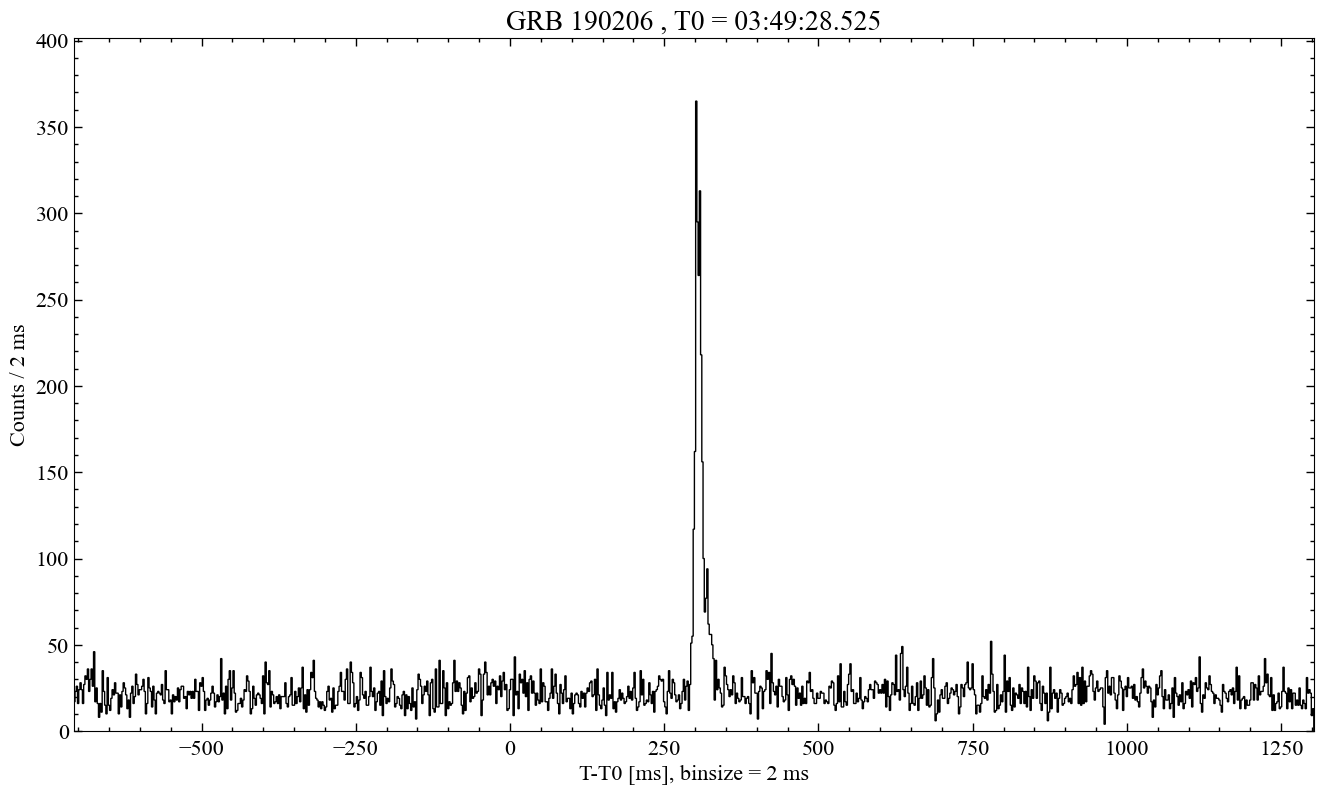

In [5]:
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

0.512


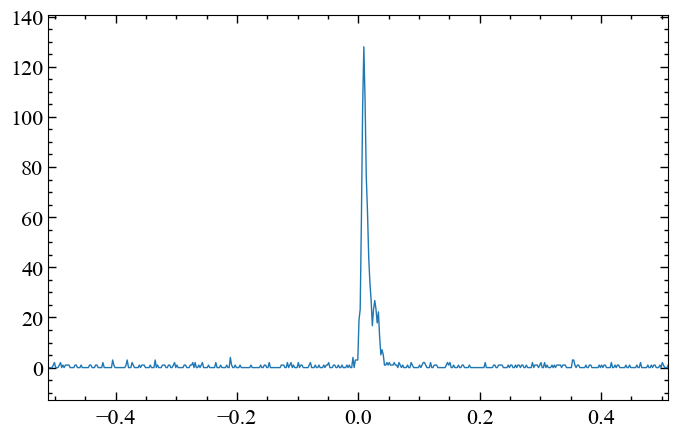

In [6]:
kw_filename = "GRB190206A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print(kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# CrossCorr debugg

## Filter tus arr by keV [350-1500]

In [7]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
indexInBound = []
for i,kev in enumerate(kevArr):
    if 350<=kev<=1500:
        indexInBound.append(i)
print(len(indexInBound))
kevArr = kevArr[indexInBound]
print(len(tus))
tus = tus[indexInBound]
print(len(kevArr),len(tus))

11721
24300
11721 11721


In [8]:
laggApprox = -0.25
tus += laggApprox
hist = plt.hist(tus,bins=kw_bin_lo,align="left",histtype="step")
asimCounts,asimEdges = hist[0],hist[1]

In [51]:
#from here the lag is approx -0.05s
#produces a tshift=-0.044s, with kwLC as lc1 and asimLC as lc2

In [9]:
asimLC = LC(time=asimEdges[:-1] + binsize/2, counts=asimCounts, skip_checks=True,dt=binsize)# +binsize/2 because we want the correct bin_lo edges

In [10]:
asimLC.bin_lo[0:5],kw_lc.bin_lo[0:5]

(array([-0.512, -0.51 , -0.508, -0.506, -0.504], dtype=float16),
 array([-0.512, -0.51 , -0.508, -0.506, -0.504], dtype=float16))

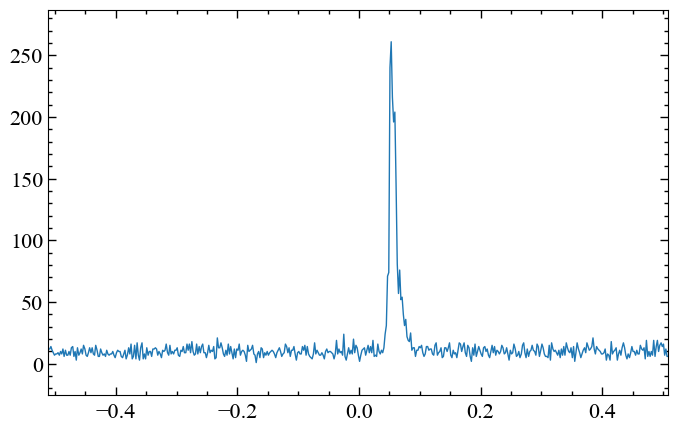

In [12]:
asimLC.plot()

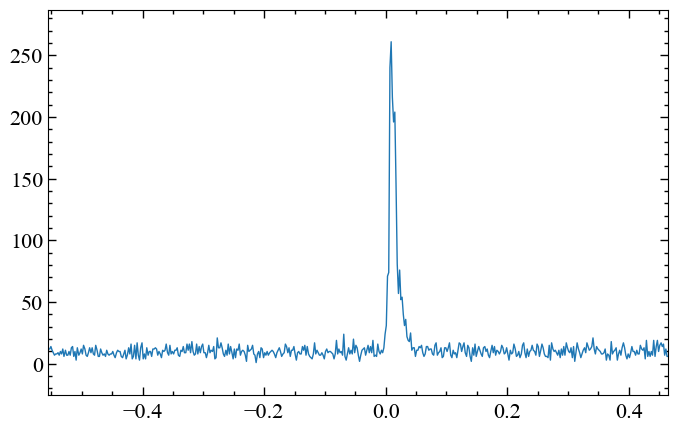

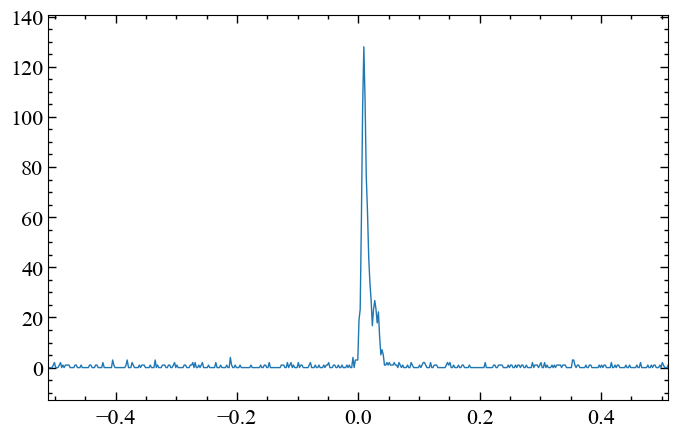

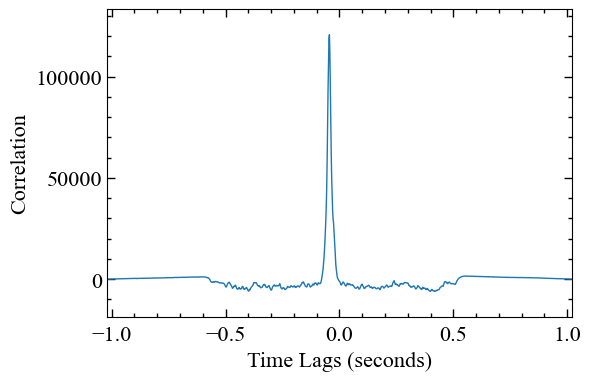

Total lagg (s):  -0.294 | CC lagg:  -0.044


In [23]:
CC = CrossCorrelation(kw_lc,asimLC,mode="full")
CClagg=CC.time_shift
asimShiftLC = asimLC.shift(CClagg)
asimShiftLC.plot()
kw_lc.plot()
#CC.plot(labels=['Time Lags (seconds)','Correlation'],title="Cross corrolation of ASIM and KW LC",save=True,filename="/Home/siv30/wad005/master/GRB/pyplots/CrossCorrolation/GRB190206A")
CC.plot(labels=['Time Lags (seconds)','Correlation'])
tlagg = CClagg + laggApprox
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)

In [25]:

ASIM_df["tus"] = ASIM_df["tus"].to_numpy() + tlagg*1e6

In [26]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
#All triggers in the time_interval are kept

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  799
n triggers are within bounds  799
keV bins are set for HED
Energies binned!


In [27]:
np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB190206_spectral_analysis/ASIM_data/HED_event.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [28]:
keV_df

,bins_keV,counts,poisson_error_counts,duration_seconds
0,1.000000E+01,-9.999000E+03,-9.999000E+03,-9.999000E+03
1,1.258925E+01,0.000000E+00,0.000000E+00,6.400000E-02
2,1.584893E+01,0.000000E+00,0.000000E+00,6.400000E-02
3,1.995262E+01,0.000000E+00,0.000000E+00,6.400000E-02
4,2.511886E+01,0.000000E+00,0.000000E+00,6.400000E-02
5,3.162278E+01,0.000000E+00,0.000000E+00,6.400000E-02
6,3.981072E+01,0.000000E+00,0.000000E+00,6.400000E-02
7,5.011872E+01,0.000000E+00,0.000000E+00,6.400000E-02
8,6.309573E+01,0.000000E+00,0.000000E+00,6.400000E-02
9,7.943282E+01,0.000000E+00,0.000000E+00,6.400000E-02


### bakground extraction 

plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

In [16]:
#From KW lc it looks like there is a precoursor that starts around T0-0.06s in the low energy band

keV_bg = keV_hist(df=ASIM_df,time_interval=(-1,-0.1),
                 keV_interval="max",
                 duration=0.9,
                 )

In [17]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')